# Time series analysis with HyP3 ISCE2 burst InSAR products and MintPy

*Note: This tutorial was adapted from [Time series analysis with HyP3 and MintPy](https://nbviewer.org/github/ASFHyP3/hyp3-docs/blob/main/docs/tutorials/hyp3_insar_stack_for_ts_analysis.ipynb), which is specific to our InSAR GAMMA products.*

This notebook demonstrates using MintPy to perform a time-series analysis of the 2014 Mount Edgecumbe, AK volcano with the Alaska Satellite Facility's ISCE2-based Sentinel-1 burst InSAR products. We'll:

1. Use the [ASF Search Python package](https://docs.asf.alaska.edu/asf_search/basics/) to:
   - Search ASF's catalog for Sentinel-1 SAR Burst products 
   - Select a reference scene to generate a baseline stack
   - Select a [short baseline subset (SBAS)](https://docs.asf.alaska.edu/vertex/sbas/) of scene pairs for InSAR processing


2. Use the [HyP3 Python SDK](https://hyp3-docs.asf.alaska.edu/using/sdk/) to:
   - Request On Demand InSAR products from ASF HyP3
   - Download the InSAR products when they are done processing


3. Use [GDAL](https://gdal.org/api/index.html#python-api) and [MintPy](https://mintpy.readthedocs.io/en/latest/) to:
   - Prepare the InSAR products for MintPy
   - perform a time-series analysis with MintPy
   
---

**Note:** This notebook does assume you have some familiarity with InSAR processing with MintPy already, and is a minimal example without much context or explanations. If you're new to InSAR and MintPy, we suggest checking out the following resources. Note that some of these resources may be specific to our InSAR GAMMA products, so you may need to adapt them for use with our ISCE2-based burst InSAR products.
* our [InSAR on Demand Story Map](https://storymaps.arcgis.com/stories/68a8a3253900411185ae9eb6bb5283d3)


* [OpenSARlab's](https://opensarlab-docs.asf.alaska.edu/) highly detailed walkthrough of using HyP3 + MintPy via these notebooks:
  * [Prepare a HyP3 InSAR Stack for MintPy](https://nbviewer.org/github/ASFOpenSARlab/opensarlab-notebooks/blob/master/SAR_Training/English/Master/Prepare_HyP3_InSAR_Stack_for_MintPy.ipynb)
  * [MintPy Time-series Analysis](https://nbviewer.org/github/ASFOpenSARlab/opensarlab-notebooks/blob/master/SAR_Training/English/Master/MintPy_Time_Series_From_Prepared_Data_Stack.ipynb)
  
    Note: While these notebooks make some assumptions you're working in OpenSARlab, you can run these 
    notebooks outside OpenSARlab by creating [this conda environment](https://github.com/ASFOpenSARlab/opensarlab-envs/blob/main/Environment_Configs/insar_analysis_env.yml).

## 0. Initial Setup

To run this notebook, you'll need a conda environment with the required dependencies. You can set up a new environment (recommended) and run the jupyter server like:
```shell
conda create -n hyp3-mintpy python=3.10 asf_search hyp3_sdk "mintpy>=1.5.2" pandas jupyter ipympl

conda activate hyp3-mintpy
jupyter notebook hyp3_isce2_burst_stack_for_ts_analysis.ipynb
```
Or, install these dependencies into your own environment:
```shell
conda install hyp3-mintpy python=3.10 asf_search hyp3_sdk "mintpy>=1.5.2" pandas jupyter ipympl

jupyter notebook hyp3_isce2_burst_stack_for_ts_analysis.ipynb
```

In [1]:

from pathlib import Path

from dateutil.parser import parse as parse_date


### Set parameters

In [2]:

project_name = '2014_mount_edgecumbe'
work_dir = Path.cwd() / project_name
data_dir = work_dir / 'data'

stack_start = parse_date('2014-05-01 00:00:00Z')
stack_end = parse_date('2015-05-01 00:00:00Z')
max_temporal_baseline =  37 #days

data_dir.mkdir(parents=True, exist_ok=True)


## 1. Select InSAR pairs with ASF Search

In [3]:

import asf_search as asf
import pandas as pd

search_results = asf.search(
        platform=asf.SENTINEL1,
        polarization=asf.VV,
        intersectsWith='POLYGON((-135.7684 57.0473,-135.7389 57.0473,-135.7389 57.0583,-135.7684 57.0583,-135.7684 57.0473))',
        start='2014-05-01',
        end='2015-05-01',
        processingLevel=asf.BURST,
        beamMode=asf.IW,
        flightDirection=asf.DESCENDING,
    )

In [4]:

baseline_results = asf.baseline_search.stack_from_product(search_results[-1])

columns = list(baseline_results[0].properties.keys()) + ['geometry', ]
data = [list(scene.properties.values()) + [scene.geometry, ] for scene in baseline_results]

stack = pd.DataFrame(data, columns=columns)
stack['startTime'] = stack.startTime.apply(parse_date)

stack = stack.loc[(stack_start <= stack.startTime) & (stack.startTime <= stack_end)]


In [13]:

sbas_pairs = set()

for reference, rt in stack.loc[::-1, ['sceneName', 'temporalBaseline']].itertuples(index=False):
    secondaries = stack.loc[
        (stack.sceneName != reference)
        & (stack.temporalBaseline - rt <= max_temporal_baseline)
        & (stack.temporalBaseline - rt > 0)
    ]
    for secondary in secondaries.sceneName:
        sbas_pairs.add((reference, secondary))


In [14]:
sbas_pairs

{('S1_372326_IW3_20141017T151617_VV_3B42-BURST',
  'S1_372326_IW3_20141110T151616_VV_96A7-BURST'),
 ('S1_372326_IW3_20141110T151616_VV_96A7-BURST',
  'S1_372326_IW3_20141204T151616_VV_0666-BURST'),
 ('S1_372326_IW3_20141204T151616_VV_0666-BURST',
  'S1_372326_IW3_20141228T151615_VV_0F12-BURST'),
 ('S1_372326_IW3_20141228T151615_VV_0F12-BURST',
  'S1_372326_IW3_20150121T151614_VV_C7F3-BURST'),
 ('S1_372326_IW3_20150121T151614_VV_C7F3-BURST',
  'S1_372326_IW3_20150214T151613_VV_29F3-BURST'),
 ('S1_372326_IW3_20150214T151613_VV_29F3-BURST',
  'S1_372326_IW3_20150310T151614_VV_8119-BURST'),
 ('S1_372326_IW3_20150310T151614_VV_8119-BURST',
  'S1_372326_IW3_20150403T151614_VV_852D-BURST'),
 ('S1_372326_IW3_20150403T151614_VV_852D-BURST',
  'S1_372326_IW3_20150427T151616_VV_F3D0-BURST')}

## 2. Request On Demand InSAR products from ASF HyP3

Use your [NASA Earthdata login](https://urs.earthdata.nasa.gov/) to connect to [ASF HyP3](https://hyp3-docs.asf.alaska.edu/).

In [15]:

import hyp3_sdk as sdk

hyp3 = sdk.HyP3('https://hyp3-test-api.asf.alaska.edu', prompt=True)

NASA Earthdata Login username:  asplayer
NASA Earthdata Login password:  ········


In [16]:

jobs = sdk.Batch()
for reference, secondary in sbas_pairs:
    job = {
        "job_parameters": {
            "apply_water_mask": False,
            "granules": [reference, secondary],
            "looks": "20x4"
        },
        "job_type": "INSAR_ISCE_BURST",
        "name": project_name
    }
    jobs += hyp3.submit_prepared_jobs([job])

In [17]:

jobs = hyp3.watch(jobs)


  0%|          | 0/8 [timeout in 10800 s]

In [18]:

jobs = hyp3.find_jobs(name=project_name)


In [19]:

insar_products = jobs.download_files(data_dir)
insar_products = [sdk.util.extract_zipped_product(ii) for ii in insar_products]


  0%|          | 0/8 [00:00<?, ?it/s]

S1_372326_IW3_20141017_20141110_VV_INT80_81CD.zip:   0%|          | 0/5381817 [00:00<?, ?it/s]

S1_372326_IW3_20141110_20141204_VV_INT80_9E2B.zip:   0%|          | 0/5395193 [00:00<?, ?it/s]

S1_372326_IW3_20150121_20150214_VV_INT80_01B5.zip:   0%|          | 0/5383829 [00:00<?, ?it/s]

S1_372326_IW3_20150214_20150310_VV_INT80_CAA6.zip:   0%|          | 0/5384151 [00:00<?, ?it/s]

S1_372326_IW3_20141204_20141228_VV_INT80_06CD.zip:   0%|          | 0/5394968 [00:00<?, ?it/s]

S1_372326_IW3_20150403_20150427_VV_INT80_2A88.zip:   0%|          | 0/5401226 [00:00<?, ?it/s]

S1_372326_IW3_20141228_20150121_VV_INT80_4D98.zip:   0%|          | 0/5438358 [00:00<?, ?it/s]

S1_372326_IW3_20150310_20150403_VV_INT80_C4BA.zip:   0%|          | 0/5417536 [00:00<?, ?it/s]

## 3. Time-series Analysis with MintPy

### 3.1 Subset all GeoTIFFs to their common overlap

In [20]:
from pathlib import Path
from typing import List, Union
from osgeo import gdal


def get_common_overlap(file_list: List[Union[str, Path]]) -> List[float]:
    """Get the common overlap of  a list of GeoTIFF files

    Arg:
        file_list: a list of GeoTIFF files

    Returns:
         [ulx, uly, lrx, lry], the upper-left x, upper-left y, lower-right x, and lower-right y
         corner coordinates of the common overlap
    """

    corners = [gdal.Info(str(dem), format='json')['cornerCoordinates'] for dem in file_list]

    ulx = max(corner['upperLeft'][0] for corner in corners)
    uly = min(corner['upperLeft'][1] for corner in corners)
    lrx = min(corner['lowerRight'][0] for corner in corners)
    lry = max(corner['lowerRight'][1] for corner in corners)
    return [ulx, uly, lrx, lry]


In [21]:

files = data_dir.glob('*/*_dem.tif')

overlap = get_common_overlap(files)


/Users/asplayer/mambaforge/envs/hyp3-mintpy/lib/python3.10/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [22]:

from pathlib import Path
from typing import List, Union

def clip_hyp3_products_to_common_overlap(data_dir: Union[str, Path], overlap: List[float]) -> None:
    """Clip all GeoTIFF files to their common overlap
    
    Args:
        data_dir:
            directory containing the GeoTIFF files to clip
        overlap:
            a list of the upper-left x, upper-left y, lower-right-x, and lower-tight y
            corner coordinates of the common overlap
    Returns: None
    """

    
    files_for_mintpy = ['_water_mask.tif',
                        '_corr.tif',
                        '_conncomp.tif',
                        '_unw_phase.tif',
                        '_dem.tif',
                        '_lv_theta.tif',
                        '_lv_phi.tif']

    for extension in files_for_mintpy:

        for file in data_dir.rglob(f'*{extension}'):

            dst_file = file.parent / f'{file.stem}_clipped{file.suffix}'

            gdal.Translate(destName=str(dst_file), srcDS=str(file), projWin=overlap)


In [23]:

clip_hyp3_products_to_common_overlap(data_dir, overlap)


### 3.2 Create the MintPy config file

In [30]:

mintpy_config = work_dir / 'mintpy_config.txt'
mintpy_config.write_text(
f"""
mintpy.load.processor        = hyp3
##---------interferogram datasets:
mintpy.load.unwFile          = {data_dir}/*/*_unw_phase_clipped.tif
mintpy.load.corFile          = {data_dir}/*/*_corr_clipped.tif
mintpy.load.connCompFile     = {data_dir}/*/*_conncomp_clipped.tif
##---------geometry datasets:
mintpy.load.demFile          = {data_dir}/*/*_dem_clipped.tif
mintpy.load.incAngleFile     = {data_dir}/*/*_lv_theta_clipped.tif
mintpy.load.azAngleFile      = {data_dir}/*/*_lv_phi_clipped.tif
mintpy.load.waterMaskFile    = {data_dir}/*/*_water_mask_clipped.tif
mintpy.troposphericDelay.method = no
##---------misc:
mintpy.plot = no
""")


1068

### 3.3 run MintPy to do the time series analysis

In [31]:

!smallbaselineApp.py --dir {work_dir} {mintpy_config}



___________________________________________________________

  /##      /## /##             /##     /#######
 | ###    /###|__/            | ##    | ##__  ##
 | ####  /#### /## /#######  /######  | ##  \ ## /##   /##
 | ## ##/## ##| ##| ##__  ##|_  ##_/  | #######/| ##  | ##
 | ##  ###| ##| ##| ##  \ ##  | ##    | ##____/ | ##  | ##
 | ##\  # | ##| ##| ##  | ##  | ## /##| ##      | ##  | ##
 | ## \/  | ##| ##| ##  | ##  |  ####/| ##      |  #######
 |__/     |__/|__/|__/  |__/   \___/  |__/       \____  ##
                                                 /##  | ##
                                                |  ######/
   Miami InSAR Time-series software in Python    \______/
          MintPy 1.5.3, 2023-11-23
___________________________________________________________

--RUN-at-2023-11-28 16:10:34.735281--
Current directory: /Users/asplayer/repos/hyp3-docs/docs/tutorials
Run routine processing with smallbaselineApp.py on steps: ['load_data', 'modify_network', 'reference_point', 'q

In [32]:

%matplotlib widget
from mintpy.cli import view, tsview


run view.py in MintPy version 1.5.3, date 2023-11-23
input file is velocity file: /Users/asplayer/repos/hyp3-docs/docs/tutorials/2014_mount_edgecumbe/velocity.h5 in float32 format
file size in y/x: (451, 1156)
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (5):
['velocity', 'velocityStd', 'intercept', 'interceptStd', 'residue']
data   coverage in y/x: (0, 0, 1156, 451)
subset coverage in y/x: (0, 0, 1156, 451)
data   coverage in lat/lon: (393760.0, 6341840.0, 486240.0, 6305760.0)
subset coverage in lat/lon: (393760.0, 6341840.0, 486240.0, 6305760.0)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [15.00, 8.00]
dataset number: 5
row     number: 3
column  number: 2
figure  number: 1
read mask from file: maskTempCoh.h5
----------------------------------------
Figure 1 - velocity.png
reading data as a list of 2D matrices ...
[==================================================

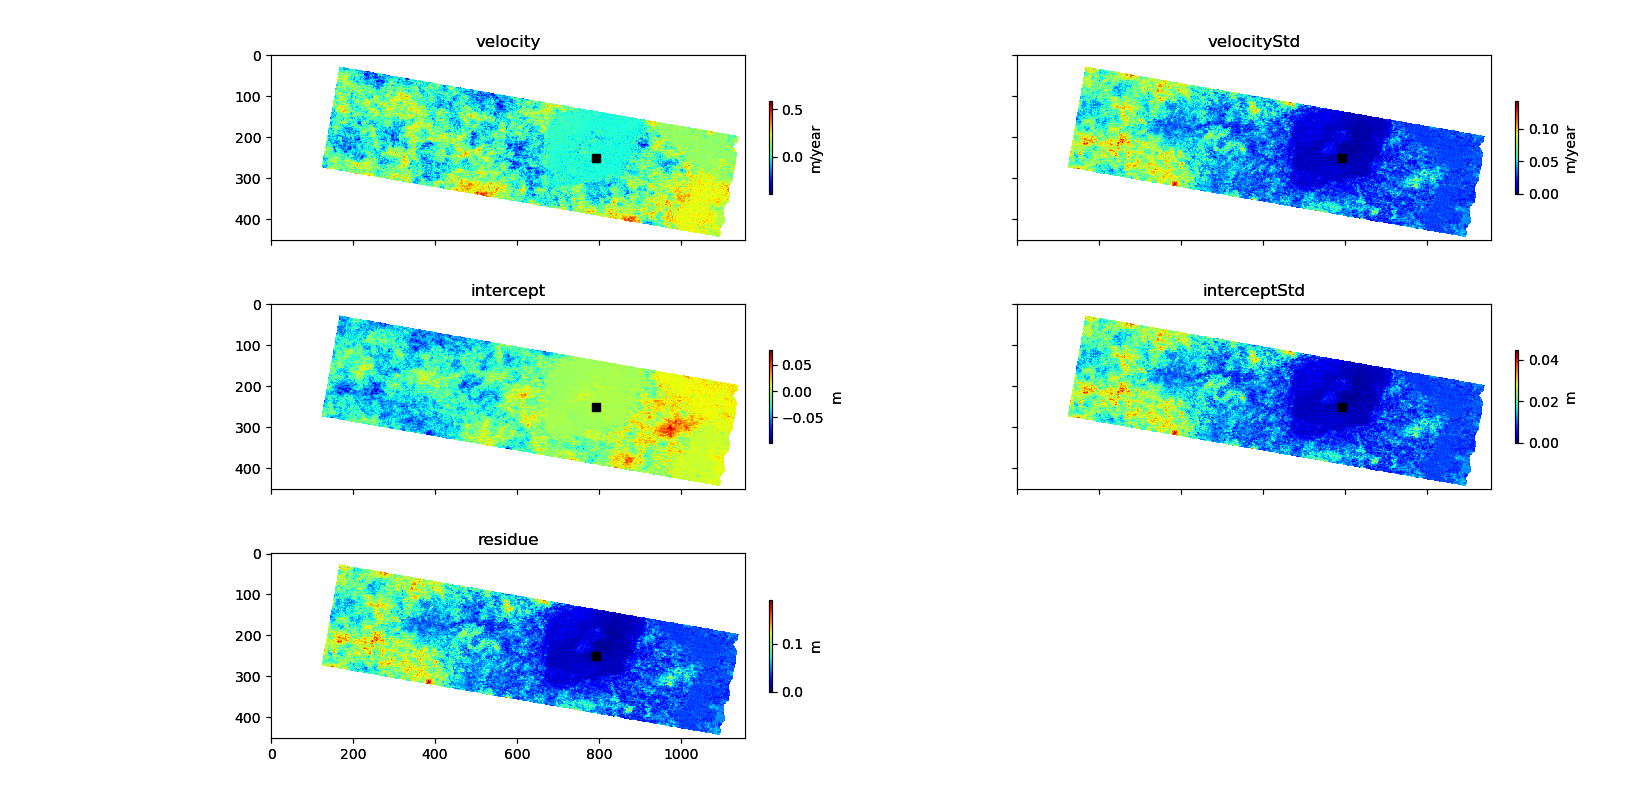

In [33]:

view.main([f'{work_dir}/velocity.h5'])


tsview.py /Users/asplayer/repos/hyp3-docs/docs/tutorials/2014_mount_edgecumbe/timeseries.h5
open timeseries file: timeseries.h5
No lookup table (longitude or rangeCoord) found in files.
data   coverage in y/x: (0, 0, 1156, 451)
subset coverage in y/x: (0, 0, 1156, 451)
data   coverage in lat/lon: (393760.0, 6341840.0, 486240.0, 6305760.0)
subset coverage in lat/lon: (393760.0, 6341840.0, 486240.0, 6305760.0)
------------------------------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    stepDate   : []
    polyline   : []
    exp        : {}
    log        : {}
reading timeseries from file /Users/asplayer/repos/hyp3-docs/docs/tutorials/2014_mount_edgecumbe/timeseries.h5
reference to date: 20141017
read mask from file: maskTempCoh.h5
data    range: [-24.540325, 29.448172] cm
display range: [-18.308758, 17.81093] cm
create figure for map in size of [3.4, 8.0]
display data in transpar

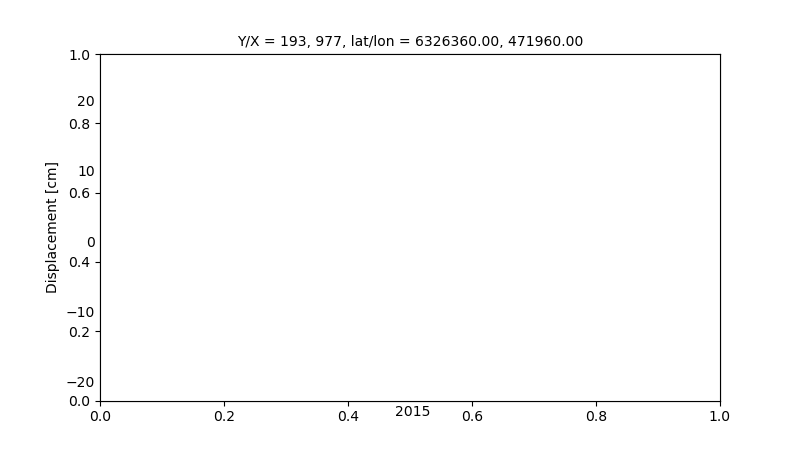

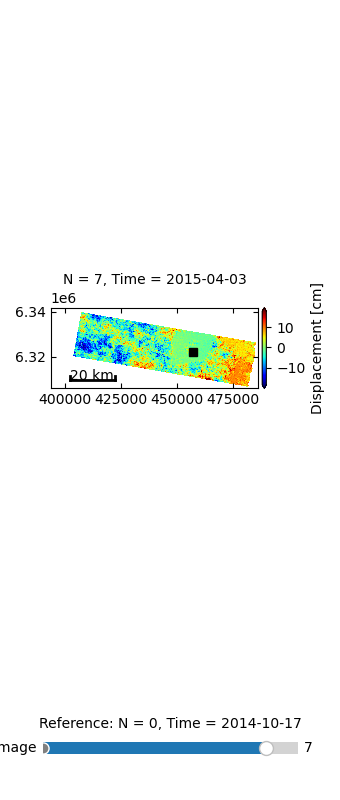

In [34]:

tsview.main([f'{work_dir}/timeseries.h5'])
